In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

# pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [4]:
from astropy.io import fits
from scipy.interpolate import interp1d

# Make a Series of OPDs

In [5]:
# Import drop models and plot OPD routine
from pynrc.opds import OTE_WFE_Drift_Model, plot_opd

import astropy.units as u

In [6]:
import webbpsf, os
webbpsf_path = webbpsf.utils.get_webbpsf_data_path()
opd_default = ('OPD_RevW_ote_for_NIRCam_requirements.fits', 0)

opd_file = opd_default[0]
opd_path = os.path.join(webbpsf_path, 'NIRCam', 'OPD', opd_file)
name = "Modified OPD from " + str(opd_file)
ote = OTE_WFE_Drift_Model(opd=opd_path, name=name)

[     poppy:INFO] Modified OPD: Loaded OPD from /Users/jwstnircam/NIRCam/webbpsf-data-0.9.0/NIRCam/OPD/OPD_RevW_ote_for_NIRCam_requirements.fits
[     poppy:INFO] No info supplied on amplitude transmission; assuming uniform throughput = 1


In [7]:
# Create a series of time values to evolve over
iec_period = 300.   # IEC heater switching period
dt = iec_period / 2 # Timing sample
burn = dt * 5       # Baseline burn time before slew
tarr = np.arange(0, 8000+burn, dt) # seconds
# tarr = np.linspace(0, 8000+burn, num=200) # seconds

# Convert to astropy units (sec)
delta_time = tarr * u.second

# Specify telescope pitch angles at each time 
slew_angles = np.zeros_like(tarr, dtype='float')
slew_angles[tarr<burn] = -5
slew_angles[tarr>=burn] = 30

In [8]:
# Set case to beginning of life
case = 'BOL'

# Generate delta OPDs for each time step
# Also outputs a dictionary of each component's WFE drift value (nm RMS)
%time dopds, wfe_dict = ote.evolve_dopd(delta_time, slew_angles, case=case, return_dopd_fin=True)

CPU times: user 3.19 s, sys: 2.04 s, total: 5.22 s
Wall time: 5.22 s


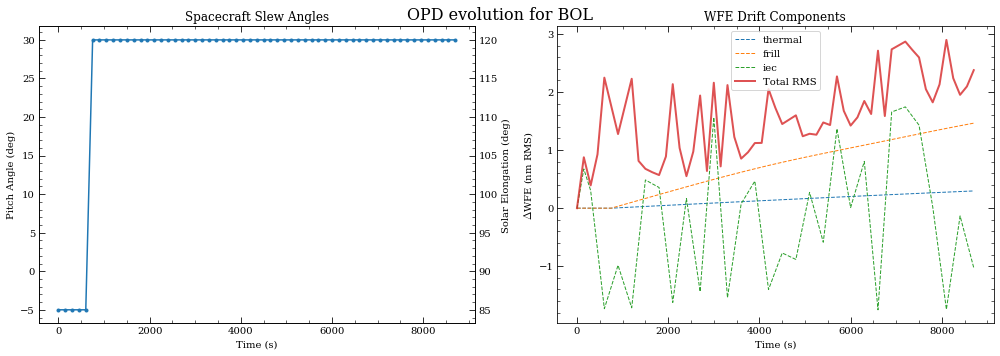

In [9]:
# Plot
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes = axes.flatten()

ax = axes[0]
ax.plot(tarr, slew_angles, marker='.')
ax.set_ylabel('Pitch Angle (deg)')
ax.set_title('Spacecraft Slew Angles')
ax2 = ax.twinx()
ax2.set_ylabel('Solar Elongation (deg)')
ax2.set_ylim(np.array(ax.get_ylim())+90)

ax = axes[1]
keys = list(wfe_dict.keys())
for k in keys:
    lw = 2 if 'total' in k else 1
    ls = '-' if 'total' in k else '--'
    alpha = 0.8 if 'total' in k else 1
    label = 'Total RMS' if 'total' in k else k
    ax.plot(tarr, wfe_dict[k], label=label, lw=lw, ls=ls, alpha=alpha)
ax.legend()

ax.set_ylabel('$\Delta$WFE (nm RMS)')
ax.set_title('WFE Drift Components')

for ax in axes:
    ax.set_xlabel(f'Time ({delta_time.unit})')

fig.suptitle(f'OPD evolution for {case}', fontsize=16)
fig.tight_layout()

In [10]:
# Save all OPDs to HDUList
# Original OPD is added to each delta OPD
# opds_hdul = ote.opds_as_hdul(delta_time, slew_angles, delta_opds=dopds, wfe_dict=wfe_dict, case=case)

# Initialize NIRCam class

In [11]:
pynrc.setup_logging('WARN', verbose=False)
obs = pynrc.NIRCam(apname='NRCA5_GRISM64_F322W2', fov_pix=65, nint=3020, ngroup=6, jitter_sigma=0.003)

In [12]:
# Create a series of PSF coefficients for each time 
from pynrc.psfs import gen_psf_coeff
from copy import deepcopy

psf_kwargs = deepcopy(obs.psf_info)

psf_kwargs['pupil'] = obs.pupil
psf_kwargs['mask'] = obs.mask
psf_kwargs['module'] = obs.module

psf_kwargs['force'] = True
psf_kwargs['save'] = False
#psf_kwargs['nproc'] = 4

detector, detector_position, apname = obs._siafap_sci_coords()
psf_kwargs['detector'] = detector
psf_kwargs['detector_position'] = detector_position
psf_kwargs['apname'] = apname


# Generate series of PSF coefficients
ncf = len(tarr)
sh_new = [ncf] + list(obs.psf_coeff.shape)
psf_coeff_all = np.zeros(sh_new, dtype='float')
for i in trange(ncf):
    # Update OPD inside an HDUList
    opd_hdul = ote.opds_as_hdul(delta_time, slew_angles, delta_opds=dopds, 
                                wfe_dict=wfe_dict, case=case, return_ind=i)
    psf_kwargs['opd'] = opd_hdul
    
    res = gen_psf_coeff(obs.filter, **psf_kwargs)
    psf_coeff_all[i] = res[0]


## Generate series of SEDs

In [13]:
# Transit spectra
file = np.load('Transits/GJ436b_Trans_SED.npz')
SEDarray = file['SEDarray']
SEDtime = file['time']
SEDwave = file['wave']

In [14]:
# BOSZ stellar spectrum

# K-Band bandpass
bp_k = pynrc.bp_2mass('k')
# Initialize stellar spectrum
sp = pynrc.stellar_spectrum('M2V', 6.073, 'vegamag', bp_k, Teff=3318, log_g=5, metallicity=-0.32)

# Bin onto common wavelength grid
sp_star = nrc_utils.bin_spectrum(sp, SEDwave)

In [15]:
# Corresponding times for each integration

tstart_oh = 700 # Overhead until start of exposure
dt = obs.multiaccum_times['t_int_tot2'] # Time between integrations
nint = obs.multiaccum.nint

# Time locations for each integration
tnew_all = (np.arange(0,nint*dt,dt) + tstart_oh) * u.s

In [26]:
import multiprocessing as mp

def get_slope_helper(args):
    
    # Hack that prevents tqdm warnings
    print(' ', end='', flush=True)
    
    obs, psf_cf, SEDwave, SEDflux = args
    
    # Update PSF coefficients
    obs._psf_coeff = psf_cf
    # Generate dispersed ideal slope image
    sp_new = S.ArraySpectrum(SEDwave*1e4, SEDflux, fluxunits='flam')
    wout, im_slope = obs.gen_psf(sp=sp_new)
    return im_slope

def outer_loop_helper(args):
    
    # Hack that prevents tqdm warnings
    print(' ', end='', flush=True)

    obs, tnew, SEDwave, flux_ratio = args
    
    # Set of new PSF coefficiencts
    cf_new = ote.interp_dopds(tarr*u.s, psf_coeff_all, tnew)

    # Get absorption spectra for each time step
    SEDflux_new = finterp_SED(tnew) * flux_ratio

    worker_args = [(obs, cf_new[i], SEDwave, SEDflux_new[i]) for i in range(len(cf_new))]
    im_slope_all = []
    for args in tqdm(worker_args, leave=False):            
        im_slope = get_slope_helper(args)
        im_slope_all.append(im_slope)

    return im_slope_all

In [ ]:
# SED interpolation function
finterp_SED = interp1d(SEDtime*24*3400, SEDarray.transpose(), axis=0)

nsplit=5

# For every 100 integrations, make a new series of PSFs
npsf = 100
niter = int(len(tnew_all) / npsf) + 1
im_slope_all = []
for ii in trange(niter):
    tnew = tnew_all[npsf*ii:npsf*(ii+1)]
    
    # Set of new PSF coefficiencts
    cf_new = ote.interp_dopds(tarr*u.s, psf_coeff_all, tnew)
    
    # Get absorption spectra for each time step
    SEDflux_new = finterp_SED(tnew) * sp_star.flux / SEDarray[:,0]
    
    worker_args = [(obs, cf_new[i], SEDwave, SEDflux_new[i]) for i in range(len(cf_new))]
    if nsplit>1:
        with mp.Pool(nsplit) as pool:
            for im_slope in tqdm(pool.imap_unordered(get_slope_helper, worker_args), total=npsf, leave=False):
                im_slope_all.append(im_slope)
            pool.close()
    else:
        for args in tqdm(worker_args, leave=False):            
            im_slope = get_slope_helper(args)
            im_slope_all.append(im_slope)
        

# tnew = tnew_all[0:100]
# %time cf = ote.interp_dopds(tarr*u.s, psf_coeff_all, tnew)

In [ ]:
# SED interpolation function
finterp_SED = interp1d(SEDtime*24*3400, SEDarray.transpose(), axis=0)

flux_ratio = sp_star.flux / SEDarray[:,0]

nsplit = 5

# For every 100 integrations, make a new series of PSFs
npsf = 100
niter = 20 #int(len(tnew_all) / npsf) + 1
im_slope_all = []

worker_args = [(obs, tnew_all[npsf*ii:npsf*(ii+1)], SEDwave, flux_ratio) for ii in range(niter)]
if nsplit>1:
    with mp.Pool(nsplit) as pool:
        for im_slope_partial in tqdm(pool.imap_unordered(outer_loop_helper, worker_args), total=niter):
            for im_slope in im_slope_partial:
                im_slope_all.append(im_slope)
        pool.close()
else:
    for args in tqdm(worker_args):            
        im_slope_partial = outer_loop_helper(args)
        for im_slope in im_slope_partial:
            im_slope_all.append(im_slope)



Process ForkPoolWorker-1166:
Process ForkPoolWorker-1165:
Process ForkPoolWorker-1162:
Process ForkPoolWorker-1163:
Process ForkPoolWorker-1164:


In [61]:
def outer_loop_helper(args):
    
    # Hack that prevents tqdm warnings
    print(' ', end='', flush=True)

    obs, tnew, SEDwave, flux_ratio = args
    
    # Set of new PSF coefficiencts
    cf_new = ote.interp_dopds(tarr*u.s, psf_coeff_all, tnew)

    # Get absorption spectra for each time step
    SEDflux_new = finterp_SED(tnew) * flux_ratio

    worker_args = [(obs, cf_new[i], SEDwave, SEDflux_new[i]) for i in range(len(cf_new))]
    im_slope_all = []
    for args in tqdm(worker_args, leave=False):            
        im_slope = get_slope_helper(args)
        im_slope_all.append(im_slope)

    return im_slope_all

In [59]:
def get_slope_helper(args):
    
    # Hack that prevents tqdm warnings
    print(' ', end='', flush=True)
    
    obs, psf_cf, SEDwave, SEDflux = args
    
    # Update PSF coefficients
    obs._psf_coeff = psf_cf
    # Generate dispersed ideal slope image
    sp_new = S.ArraySpectrum(SEDwave*1e4, SEDflux, fluxunits='flam')
    wout, im_slope = obs.gen_psf(sp=sp_new)
    return im_slope

In [17]:
tnew_all.shape

(3020,)

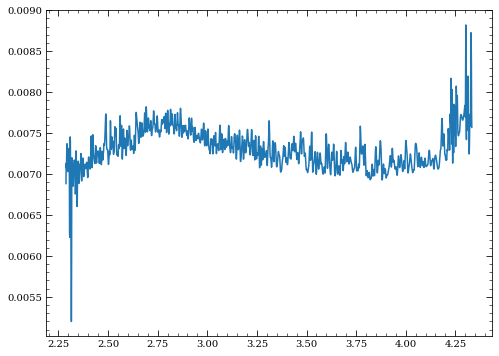

In [71]:
# plt.plot(wout, im_slope_all[1][32,:])

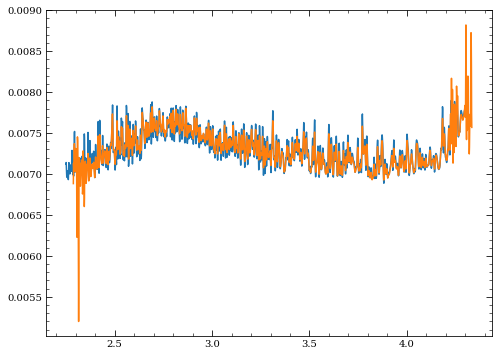

In [76]:
f0 = finterp_SED(tnew_all[0]) * sp_star.flux / SEDarray[:,0]
f1 = finterp_SED(tnew_all[1000]) * sp_star.flux / SEDarray[:,0]

ind = (SEDwave>2.25) & (SEDwave<4.3)
plt.plot(SEDwave[ind], 1-f1[ind]/f0[ind])

plt.plot(wout[100:], 1-im_slope_all[1000][32-5:32+5,100:].sum(axis=0)/im_slope_all[0][32-5:32+5,100:].sum(axis=0))


In [59]:
sp0_new = S.ArraySpectrum(SEDwave*1e4, f0, fluxunits='flam')
sp1_new = S.ArraySpectrum(SEDwave*1e4, f1, fluxunits='flam')

wout, im_slope0 = obs.gen_psf(sp=sp0_new)
wout, im_slope1 = obs.gen_psf(sp=sp1_new)

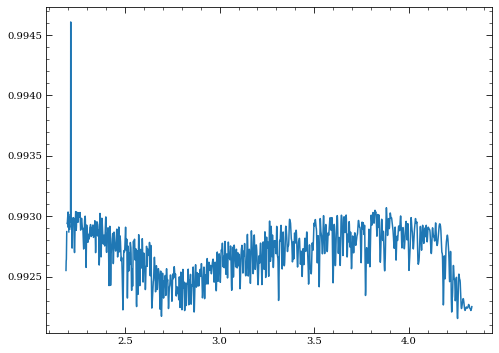

In [60]:
plt.plot(wout, im_slope1[32,:]/im_slope0[32,:])

In [54]:
tnew_all[2000]

<Quantity 5479.02 s>

In [104]:
cf = ote.interp_dopds(tarr*u.s, psf_coeff_all, tnew_all[10])

In [296]:
ii=10
tnew = tnew_all[npsf*ii:npsf*(ii+1)]

In [329]:
SEDflux_new = finterp_SED(tnew) * sp_star.flux / SEDarray[:,0]

In [330]:
%time sp_new = S.ArraySpectrum(SEDwave*1e4, SEDflux_new[10], fluxunits='flam')

CPU times: user 817 µs, sys: 603 µs, total: 1.42 ms
Wall time: 773 µs


In [18]:
wout, im_slope = obs.gen_psf(sp=sp)

In [20]:
wout, im_slope2 = obs.gen_psf(sp=sp_star)

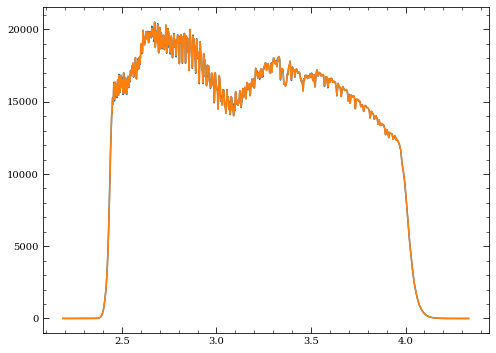

In [21]:
plt.plot(wout, im_slope[32,:])
plt.plot(wout, im_slope2[32,:])

In [333]:
obs.multiaccum_times

{'t_frame': 0.34061,
 't_group': 0.34061,
 't_int': 2.04366,
 't_exp': 6171.8532000000005,
 't_acq': 7216.325440000001,
 't_int_tot1': 2.3895100000000005,
 't_int_tot2': 2.3895100000000005}

In [338]:
im_slope.max() * obs.multiaccum_times['t_group'] * 6

41074.82453548909

In [339]:
res2 = obs.saturation_levels(sp_new, ngroup=6, image=im_slope)

In [340]:
res2.max()

0.5134353066936135

In [304]:
test.shape

(100, 3500)

In [234]:
def bin_spectrum(sp, wave, waveunits='um'):
    """Rebin spectrum

    Rebin a :mod:`pysynphot.spectrum` to a lower wavelength grid.
    This function first converts the input spectrum to units
    of counts then combines the photon flux onto the
    specified wavelength grid.

    Output spectrum units are the same as the input spectrum.

    Parameters
    -----------
    sp : :mod:`pysynphot.spectrum`
        Spectrum to rebin.
    wave : array_like
        Wavelength grid to rebin onto.
    waveunits : str
        Units of wave input. Must be recognizeable by Pysynphot.

    Returns
    -------
    :mod:`pysynphot.spectrum`
        Rebinned spectrum in same units as input spectrum.
    """
    
    from pynrc.maths.image_manip import binned_statistic
    from scipy.interpolate import griddata, RegularGridInterpolator, interp1d

    waveunits0 = sp.waveunits
    fluxunits0 = sp.fluxunits

    # Convert wavelength of input spectrum to desired output units
    sp.convert(waveunits)
    # We also want input to be in terms of counts to conserve flux
    sp.convert('flam')

    edges = S.binning.calculate_bin_edges(wave)
    ind = (sp.wave >= edges[0]) & (sp.wave <= edges[-1])
    binflux = binned_statistic(sp.wave[ind], sp.flux[ind], np.mean, bins=edges)
    
    # Interpolate over NaNs
    ind_nan = np.isnan(binflux)
    finterp = interp1d(wave[~ind_nan], binflux[~ind_nan])
    binflux[ind_nan] = finterp(wave[ind_nan])

    sp2 = S.ArraySpectrum(wave, binflux, waveunits=waveunits, fluxunits='flam')
    sp2.convert(waveunits0)
    sp2.convert(fluxunits0)

    # Put back units of original input spectrum
    sp.convert(waveunits0)
    sp.convert(fluxunits0)

    return sp2

In [276]:
# At the given timestep, determine absorption spectrum



In [277]:
test = finterp_SED(np.array([100,200]))

In [278]:
test.shape

(2, 3500)

In [ ]:
# Update PSF coefficient
obs._psf_coeff = cf
obs.gen_psf(sp_new)

In [269]:
SEDarray.shape

(3500, 5000)

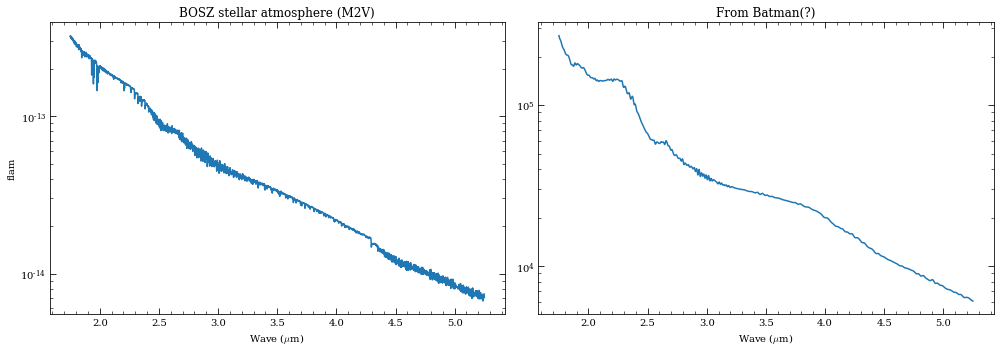

In [259]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].semilogy(Wave, sp3.flux)
axes[0].set_title('BOSZ stellar atmosphere (M2V)')
axes[0].set_ylabel(sp2.fluxunits)

axes[1].semilogy(Wave,SEDarray[:,0])
axes[1].set_title('From Batman(?)')

for ax in axes:
    ax.set_xlabel(r'Wave ($\mu$m)')

fig.tight_layout()

In [118]:
Sobs.countrate()

1.033504750155504e+26

In [107]:
res = obs.gen_psf()

jl_poly: 0.49 sec; binflux: 0.12 sec; disperse: 3.16 sec


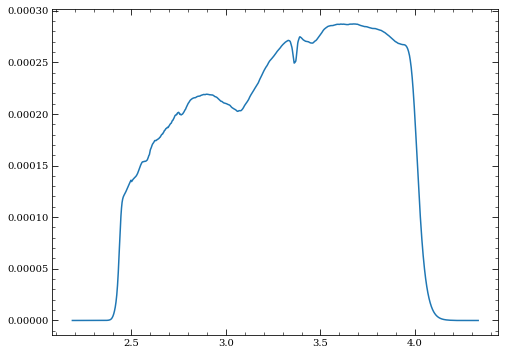

In [110]:
plt.plot(res[0], res[1][32,:])

In [109]:
res[1].shape

(65, 2140)

In [ ]:
def psf_coeff_interp(tval, psf_coeff_all, interp_kind = 'linear'):
    

dt_new = np.linspace(10,800,num=3000)*u.s

unit = delta_time.unit
dt_new_vals = dt_new.to(unit)

# Create interpolation function
dt_vals = delta_time[0:10].to(unit)
%time func = scipy.interpolate.interp1d(dt_vals, psf_coeff_all, axis=0, kind=interp_kind, bounds_error=True)

%time psf_coeff_new = func(dt_new_vals)


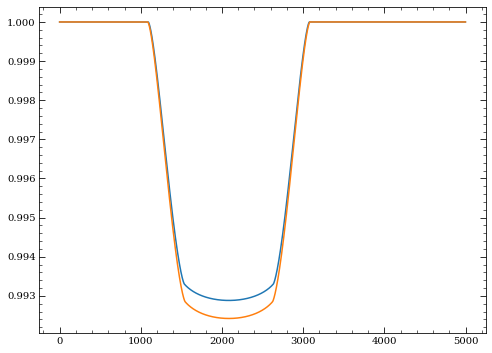

In [51]:
plt.plot(SEDarray[100,:] / SEDarray[100,0])
plt.plot(SEDarray[1000,:] / SEDarray[1000,0])

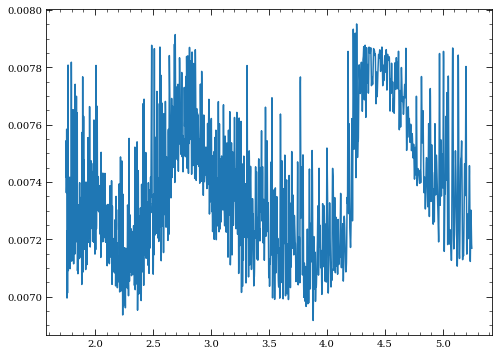

In [61]:
# diff = SEDarray[:,0]-SEDarray[:,2000]
plt.plot(Wave, 1 - SEDarray[:,2000] / SEDarray[:,0])

In [16]:
psf_coeff_all.shape

(10, 10, 260, 260)

Text(0.5, 0, 'Wavelength2 ($\\mu m$)')

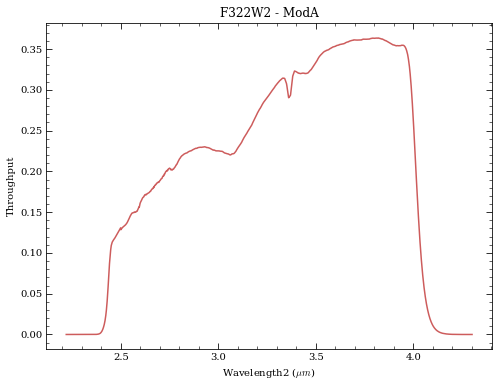

In [64]:
fig, ax = plt.subplots(1,1)
obs.plot_bandpass(ax=ax)
ax.set_xlabel(r'Wavelength2 ($\mu m$)')

In [65]:
test = None
test.asldfj()

AttributeError: 'NoneType' object has no attribute 'asldfj'

Text(0.5, 0, 'Time (h)')

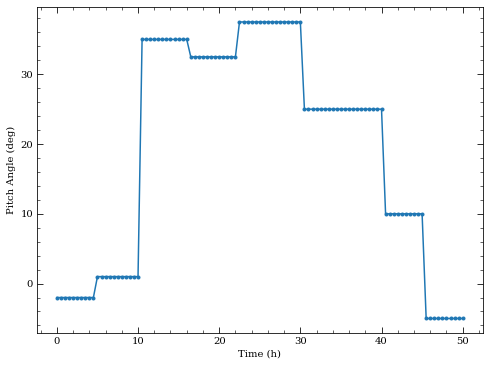

In [8]:
# Create a series of time values to evolve over
burn = 100
dt = obs_lw.multiaccum_times['t_int1_tot']
nt = (8000+burn) / dt
tarr = np.linspace(0,8000,num=101) # seconds

# Convert to astropy units (hrs)
delta_time = tarr * u.sec

# Set case to beginning of life
case = 'BOL'

# Specify telescope pitch angles at each time 
slew_angles = np.zeros_like(tarr, dtype='float')

slew_angles[tarr<5] = 0
slew_angles[tarr>=5] = 1
slew_angles[tarr>10] = 35
slew_angles[tarr>16] = 32.5
slew_angles[tarr>22] = 37.5
slew_angles[tarr>30] = 25
slew_angles[tarr>40] = 10
slew_angles[tarr>45] = -5

plt.plot(delta_time, slew_angles, marker='.')
plt.ylabel('Pitch Angle (deg)')
plt.xlabel(f'Time ({delta_time.unit})')

In [9]:
# Generate delta OPDs for each time step
# Also outputs a dictionary of each component's WFE drift value (nm RMS)
dopds, wfe_dict = ote.evolve_dopd(delta_time, slew_angles, case=case, return_dopd_fin=True)

In [10]:
# Calculate averages over each slew position
res = ote.slew_pos_averages(delta_time, slew_angles, opds=dopds, wfe_dict=wfe_dict)
dt_new, dopds_new, wfe_dict_new = res

islew = np.where(slew_angles[1:] - slew_angles[:-1] != 0)[0] + 1
islew = np.concatenate(([0], islew))
ang_new = slew_angles[islew]

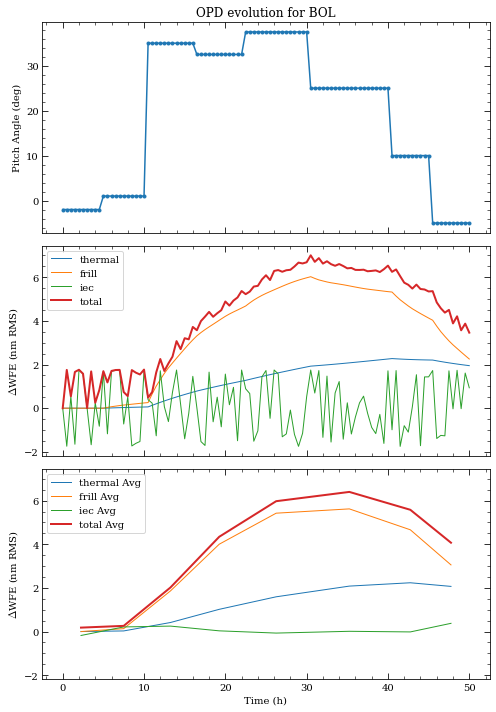

In [11]:
# Plot
fig, axes = plt.subplots(3,1, figsize=(7,10), sharex=True)
axes = axes.flatten()

ax = axes[0]
ax.plot(tarr, slew_angles, marker='.')
ax.set_ylabel('Pitch Angle (deg)')
ax.set_title(f'OPD evolution for {case}')

ax = axes[1]
keys = list(wfe_dict.keys())
for k in keys:
    lw = 2 if 'total' in k else 1
    ax.plot(tarr, wfe_dict[k], label=k, lw=lw)
    
ax = axes[2]
for k in keys:
    lw = 2 if 'total' in k else 1
    ax.plot(dt_new, wfe_dict_new[k], label=f'{k} Avg', lw=lw)
ax.set_xlabel(f'Time ({delta_time.unit})')
ax.set_ylim(axes[1].get_ylim())
    
for ax in axes[1:]:
    ax.legend()
    ax.set_ylabel('$\Delta$WFE (nm RMS)')

fig.tight_layout()

In [4]:
import pysiaf
siaf_nrc = pysiaf.Siaf('NIRCam')
siaf_nrc.generate_toc()

In [5]:
siaf_nrc.apernames

odict_keys(['NRCA1_FULL_OSS', 'NRCA2_FULL_OSS', 'NRCA3_FULL_OSS', 'NRCA4_FULL_OSS', 'NRCA5_FULL_OSS', 'NRCB1_FULL_OSS', 'NRCB2_FULL_OSS', 'NRCB3_FULL_OSS', 'NRCB4_FULL_OSS', 'NRCB5_FULL_OSS', 'NRCALL_FULL', 'NRCAS_FULL', 'NRCA1_FULL', 'NRCA2_FULL', 'NRCA3_FULL', 'NRCA4_FULL', 'NRCA5_FULL', 'NRCBS_FULL', 'NRCB1_FULL', 'NRCB2_FULL', 'NRCB3_FULL', 'NRCB4_FULL', 'NRCB5_FULL', 'NRCA1_SUB160', 'NRCA2_SUB160', 'NRCA3_SUB160', 'NRCA4_SUB160', 'NRCA5_SUB160', 'NRCA1_SUB320', 'NRCA2_SUB320', 'NRCA3_SUB320', 'NRCA4_SUB320', 'NRCA5_SUB320', 'NRCA1_SUB640', 'NRCA2_SUB640', 'NRCA3_SUB640', 'NRCA4_SUB640', 'NRCA5_SUB640', 'NRCB1_SUB160', 'NRCB2_SUB160', 'NRCB3_SUB160', 'NRCB4_SUB160', 'NRCB5_SUB160', 'NRCB1_SUB320', 'NRCB2_SUB320', 'NRCB3_SUB320', 'NRCB4_SUB320', 'NRCB5_SUB320', 'NRCB1_SUB640', 'NRCB2_SUB640', 'NRCB3_SUB640', 'NRCB4_SUB640', 'NRCB5_SUB640', 'NRCA5_GRISM256_F322W2', 'NRCA5_GRISM128_F322W2', 'NRCA5_GRISM64_F322W2', 'NRCA5_GRISM256_F277W', 'NRCA5_GRISM128_F277W', 'NRCA5_GRISM64_F277W', 

In [7]:
%time obs_lw = pynrc.NIRCam(apname='NRCA5_GRISM64_F322W2', fov_pix=65)

[     pynrc:INFO] Initializing SCA 485/A5
[     pynrc:INFO] Updating PSF coeff with fov_pix=65 and oversample=4
[     pynrc:INFO] Generating and saving new PSF coefficient
[     pynrc:INFO] Took 10.81 seconds to generate WebbPSF images
CPU times: user 1.27 s, sys: 245 ms, total: 1.51 s
Wall time: 11.9 s


In [8]:
res1 = obs_lw.gen_psf()

jl_poly: 0.51 sec; binflux: 0.12 sec; disperse: 3.21 sec


In [9]:
res2 = obs_lw.gen_webbpsf()

[     pynrc:INFO] Generating and returning WebbPSF HDUList
[     pynrc:INFO] Took 5.36 seconds to generate WebbPSF images


In [10]:
res2.shape

(65, 65)

In [11]:
res1[1].shape

(65, 2140)

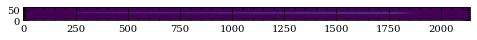

In [12]:
plt.imshow(res1[1])